In [1]:
#Importing Packages
import pandas as pd
import numpy as np
import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
stop_words = stopwords.words("english")
wordnet = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Metrics/Evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#Display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

[nltk_data] Downloading package punkt to /home/rajesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rajesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/rajesh/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rajesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
"""Method to Clean the Messages. Calling this method on a text will chagne the case to lowercase, 
remove the stopwords, remove urls, remove mentions, remove hastags etc"""
def text_preproc(x):
  x = x.lower() #lowercase
  x = ' '.join([word for word in x.split(' ') if word not in stop_words]) #remove stop words
  x = ' '.join([wordnet.lemmatize(word) for word in x.split()]) #lemmatize
  x = re.sub(r'https*\S+', ' ', x) #remove url
  x = re.sub(r'@\S+', ' ', x) #remove mentions
  x = re.sub(r'#\S+', ' ', x) #remove hashtags
  x = re.sub(r'\'\w+', '', x) #remove ticks and next character
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x) #remove punctuations
  x = re.sub(r'\w*\d+\w*', '', x) #remove numbers
  x = re.sub(r'\s{2,}', ' ', x) #replace over spaces
  x = ' '.join([x for x in x.split() if len(x) > 3]) #remove words less than 3 letters
  return x

In [3]:
#Model evaluation using best parameters

#Creating a dict of the models
model_dict = {'GaussianNB' : GaussianNB(),
              'BernoulliNB': BernoulliNB(),
              'MultinomialNB': MultinomialNB()}


#Function to get the scores for each model in a dataframe
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

In [4]:
#Reading the Data
df=pd.read_csv('spam@.csv',encoding='latin-1')
df.drop_duplicates(inplace = True) #Remove Duplicates
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [5]:
#selecting only the messagegs from the original dataset as the content for training
filtered_df  = df[["v1","v2"]]
filtered_df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
filtered_df['cleaned_text'] = filtered_df['v2'].apply(text_preproc)
filtered_df

,v1,v2,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,joking
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp final tkts text receive e...
3,ham,U dun say so early hor... U c already then say...,early already
4,ham,"Nah I don't think he goes to usf, he lives aro...",think life around though
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,time tried contact pound prize claim easy call...
5568,ham,Will Ì_ b going to esplanade fr home?,going esplanade home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood that suggestions
5570,ham,The guy did some bitching but I acted like i'd...,bitching acted like interested buying somethin...


In [7]:
display(filtered_df.groupby(['v1'])['cleaned_text'].count())

v1
ham     4516
spam     653
Name: cleaned_text, dtype: int64

In [8]:
#Turning the labels into numbers
LE = LabelEncoder()
filtered_df['label_num'] = LE.fit_transform(filtered_df['v1'])

In [9]:
filtered_df

,v1,v2,cleaned_text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis great world...,0
1,ham,Ok lar... Joking wif u oni...,joking,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp final tkts text receive e...,1
3,ham,U dun say so early hor... U c already then say...,early already,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",think life around though,0
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,time tried contact pound prize claim easy call...,1
5568,ham,Will Ì_ b going to esplanade fr home?,going esplanade home,0
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood that suggestions,0
5570,ham,The guy did some bitching but I acted like i'd...,bitching acted like interested buying somethin...,0


In [10]:
#Creating the features (tf-idf weights) for the processed text

texts = filtered_df['cleaned_text'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  #(1,2) means unigrams and bigrams
                                   min_df = 2,          #document frequency strictly lower than the given threshold
                                   max_df = .95)        #document frequency strictly higher than the given threshold

X = tfidf_vectorizer.fit_transform(texts) #features
y = filtered_df['label_num'].values #target

#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), 
                                                    y, 
                                                    test_size = .2, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

y


(4135, 5039)
(1034, 5039)
(4135,)
(1034,)


array([0, 0, 1, ..., 0, 0, 0])

In [11]:

model_score_df(model_dict)

,model_name,accuracy_score,precision_score,recall_score,f1_score
2,MultinomialNB,0.97,0.98,0.88,0.92
1,BernoulliNB,0.97,0.96,0.89,0.92
0,GaussianNB,0.88,0.74,0.87,0.78


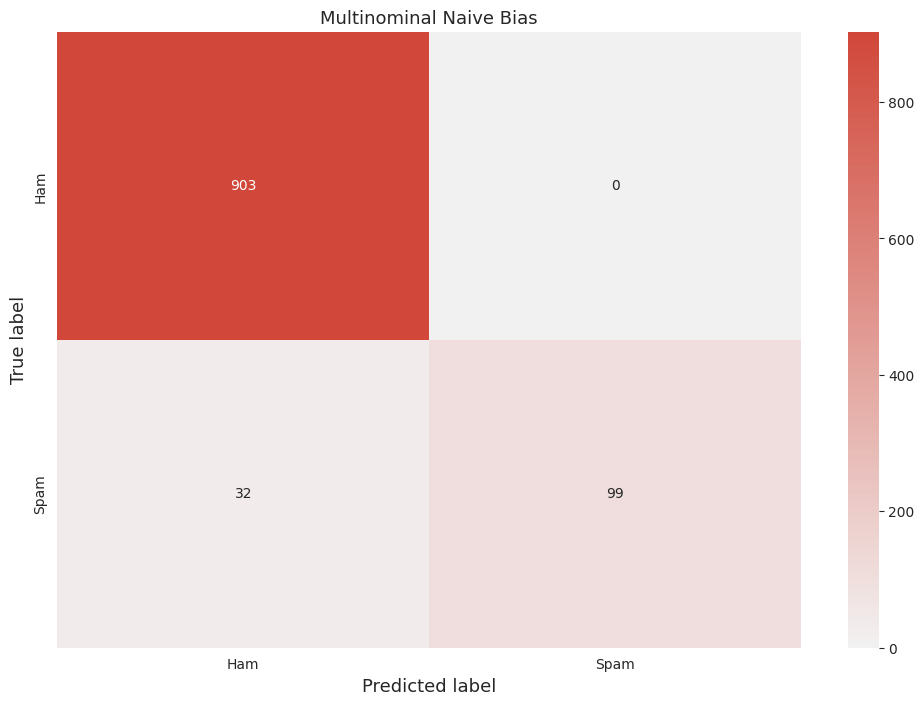

In [12]:
mnb = MultinomialNB()

#Fit the training data
mnb.fit(X_train, y_train)

#Predict the testing data
y_pred = mnb.predict(X_test)

#Get the confusion matrix and put it into a df
cm = confusion_matrix(y_test, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['Ham', 'Spam'], 
                     columns = ['Ham','Spam'])
#Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(220, 15, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title('Multinominal Naive Bias'.format(f1_score(y_test, y_pred, average='macro')), fontsize = 13)
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

Exporting Models for Inference

In [13]:
import pickle
pickle.dump(tfidf_vectorizer,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))